In [1]:
#library imports
import os
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_img = Path('/content/drive/MyDrive/Q3/images')
path_ann = Path('/content/drive/MyDrive/Q3/annotations')

In [8]:
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, files in os.walk(root) for f in files if f.endswith(file_type)]

def Img_df (path_ann):
    annotations = filelist(path_ann, '.xml')
    ann_list = []
    for path_ann in annotations:
        root = ET.parse(path_ann).getroot()
        ann = {}
        ann['filename'] = Path(str(path_img) + '/'+ root.find("./filename").text)
        ann['xmin'] = int(root.find("./object/bndbox/xmin").text)
        ann['ymin'] = int(root.find("./object/bndbox/ymin").text)
        ann['xmax'] = int(root.find("./object/bndbox/xmax").text)
        ann['ymax'] = int(root.find("./object/bndbox/ymax").text)
        ann_list.append(ann)
    return pd.DataFrame(ann_list)

In [9]:
df_train = Img_df(path_ann)

In [10]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [14]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[2],x[1],x[4],x[3]])

In [12]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [15]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Q3/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),30)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [16]:
X=[]
for i in range(0, 877):
  im = read_image(df_train.values[i][5])
  im_v=im.flatten()
  X.append(im_v)
X=np.array(X)

In [17]:
Y = df_train['new_bb'].to_numpy().copy()
Z =[]
for i in range(0,877):
  Z.append(Y[i])
Z= np.array(Z)
Y = Z

In [18]:
def MSE(X, Y, w_opt):
  Y_ = np.matmul(X, w_opt)
  mse = 0
  for i in range(0,877):
    mse += np.linalg.norm(Y_-Y)
  return mse

In [19]:
def MAE(X, Y, w_opt):
  Y_ = np.matmul(X, w_opt)
  mae = 0
  for i in range(0,877):
    mae += np.sum(np.absolute(Y_-Y))
  mae = mae /(877*4)
  return mae

lambda: 0 MSE: 747400675614.892 MSA: 9517792056.750782
lambda: 1 MSE: 590676429556.0206 MSA: 7564945302.390932
lambda: 2 MSE: 709854789492.7926 MSA: 9373196661.69824
lambda: 3 MSE: 2276868619775.118 MSA: 30105215224.608395
lambda: 4 MSE: 1559345213528.404 MSA: 20613926994.884335
lambda: 5 MSE: 9480044854349.842 MSA: 121492670112.29715
lambda: 6 MSE: 443105770837.3673 MSA: 5686933126.45988
lambda: 7 MSE: 389139259597.2407 MSA: 4955646213.344728
lambda: 8 MSE: 15985540276914.688 MSA: 193561798780.90546
lambda: 9 MSE: 293388990367.8625 MSA: 3774352794.876496


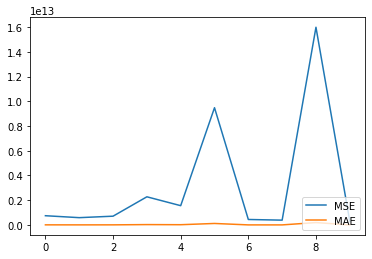

In [20]:
L = []
MSErr = []
MAErr = []
# Ridge Regression 
for lam in range(0, 10):
  w_opt= np.matmul(np.linalg.pinv(np.matmul(X.T,X) - lam * np.eye(3960)),np.matmul(X.T,Y))
  mse = MSE(X, Y, w_opt)
  mae = MAE(X, Y, w_opt)
  L.append(lam)
  MSErr.append(mse)
  MAErr.append(mae)
  print('lambda:',lam, 'MSE:', mse,'MSA:', mae)


plt.plot(MSErr)
plt.plot(MAErr)
  
# Function add a legend  
plt.legend(["MSE", "MAE"], loc ="lower right")
  
# function to show the plot
plt.show()